# S1 - Federated Learning for IoT and Smart Cities

## Code Structure

1. Setup enviroment by importing libs and dataset
2. Preprocess the data by
- Flatten the data
- Selects clients (if needed)
- Batch and create dict
3. Prepare the model
- Keras model 
- Create layers
- Cast keras model to tff-model
4. Build and test FL algorithm
- Initialization of model on server.
Then as a "loop" :
- server-to-client broadcast step.
- local client update step.
- client-to-server upload step.
- server update step

### 1. Setup enviroment & load dataset

In [29]:
#Reset all variables from previous run
%reset -f
#Import pyplot for plotting evaluation of model
from matplotlib import pyplot

In [30]:
import nest_asyncio
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff # this might register as non-resolved but seems to work
np.random.seed(0)
nest_asyncio.apply()
# check if tff works correctly
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

Load the EMNIST data set of 3383 users, split into training and test sets.

The data split is approximately 89,3 % training and 10,7% test. (341 873 vs 40 832 examples, to be exact)

In [31]:
#Load EMNIST dataset
emnist_dataset, dummy = tff.simulation.datasets.emnist.load_data()

### 2. Process the data

In [32]:
#How many of the 3383 clients to use for training and testing, respectively
NUM_TRAIN_CLIENTS = 250
NUM_TEST_CLIENTS = 50
#The batch size used in training
BATCH_SIZE = 5
#Number of rounds to run the algorithm
ROUNDS = 100


Flatten batches of data, and conver to a tuple (flattened_image_vector, label)

In [33]:
def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    return (tf.reshape(element['pixels'], [-1, 784]), 
            tf.reshape(element['label'], [-1, 1]))

  return dataset.batch(BATCH_SIZE).map(batch_format_fn)

Select a small subset of clients, and apply the above created preprocessing to them

In [34]:
#Split clients into train and test groups 
training_dataset, test_dataset = emnist_dataset.train_test_client_split(client_data=emnist_dataset,num_test_clients=NUM_TEST_CLIENTS)

#Define the client IDs of the clients to be used for training and testing
client_ids_train = sorted(training_dataset.client_ids)[:NUM_TRAIN_CLIENTS]

#Create training data by preprocessing dataset for clients in training set
federated_train_data = [preprocess(emnist_dataset.create_tf_dataset_for_client(x))
  for x in client_ids_train
]

#Create central evaluation dataset by preprocessing a single dataset for all clients in test set 
central_emnist_test = test_dataset.create_tf_dataset_from_all_clients()
central_emnist_test = preprocess(central_emnist_test)

## 3. Preparing the model

Create a keras ML model, with one hidden layer and a softmax layer

In [35]:
def create_keras_model():
  initializer = tf.keras.initializers.GlorotNormal(seed=0)
  #Create keras model, and return
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer=initializer),
      tf.keras.layers.Softmax(),
  ])

Wrap this model as a 'tff.learning.Model' for use in Tensorflow Federated

In [36]:
def model_fn():
  #Call on function for creating a keras moedl
  keras_model = create_keras_model()
  
  #Convert to TFF model, and return
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=federated_train_data[0].element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## 4. Building our own FL algorithm

Create functions for initializing the server (initialize_fn), as well as performing one round of communication in the FL algorithm (next_fn)

### 4.2 Client update step

Gradient descent(?)

In [37]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights.
  client_weights = model.trainable_variables
  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y), client_weights, server_weights)

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    with tf.GradientTape() as tape:
      # Compute a forward pass on the batch of data
      outputs = model.forward_pass(batch)

    # Compute the corresponding gradient
    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)

    # Apply the gradient using a client optimizer.
    client_optimizer.apply_gradients(grads_and_vars)

  return client_weights

### 4.4 Server update step

A simple "FedAvd" update (aka "vanilla FL")

In [38]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  model_weights = model.trainable_variables
  # Assign the mean client weights to the server model.
  tf.nest.map_structure(lambda x, y: x.assign(y), model_weights, mean_client_weights)
  return model_weights

### Federated core

In summary:

TFF operates on federated values.
Each federated value has a federated type, with a type (eg. tf.float32) and a placement (eg. tff.CLIENTS).
Federated values can be transformed using federated computations, which must be decorated with tff.federated_computation and a federated type signature.
TensorFlow code must be contained in blocks with tff.tf_computation decorators.
These blocks can then be incorporated into federated computations.

## 5.

Create tf_computation for initializing the model.

In [39]:
@tff.tf_computation
def server_init():
  model = model_fn()
  return model.trainable_variables

Create federated computation to call server_init

In [40]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)

### Client update

Get datatype of dataset and model weights

In [41]:
# 
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)
model_weights_type = server_init.type_signature.result

Declare tff function for client update with keras gradient descent

In [42]:
@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  model = model_fn()
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  return client_update(model, tf_dataset, server_weights, client_optimizer)

Declare tff function for server update (FedAvg)

In [43]:
@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
  model = model_fn()
  return server_update(model, mean_client_weights)

Create federated types for server and clients

In [44]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

Iteration function to update weights (steps 1-4)

In [45]:
# input: datatypes
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
  # Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # Each client computes their updated weights.
  client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
  
  # The server averages these updates.
  mean_client_weights = tff.federated_mean(client_weights)

  # The server updates its model.
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights

Create a tff iterative process

In [46]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

Create a evaluation function using keras

In [47]:
def evaluate(server_state):
  keras_model = create_keras_model()
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()] 
  )
  keras_model.set_weights(server_state)
  results = keras_model.evaluate(central_emnist_test)
  return results

In [59]:
# Initialize FL model
import pandas as pd
server_state = federated_algorithm.initialize()
#results_df = pd.DataFrame(evaluate(server_state))
results_list = [evaluate(server_state)]

# Perform iteration rounds for FL model 
for round in range(ROUNDS):
  server_state = federated_algorithm.next(server_state, federated_train_data)
  # Evaluate model test accuracy and loss every 10 rounds
  if round % 10 == 0:
    results_list.append(evaluate(server_state))

#Evaluate final state
results_list.append(evaluate(server_state))


100/100 [==============================] - 0s 2ms/step - loss: 3.4647 - sparse_categorical_accuracy: 0.1500


In [71]:
import pandas as pd
results_df = pd.DataFrame(results_list,columns=['loss','accuracy'])

Plot test results in graph

Text(0.5, 1.0, 'Accuracy')

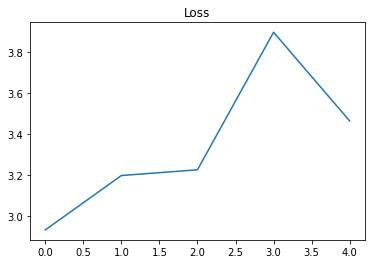

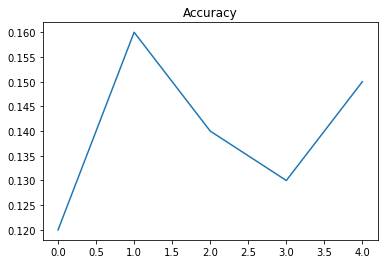

In [73]:
fig_loss, ax_loss = pyplot.subplots()
ax_loss.plot(results_df.loss)
ax_loss.set_title('Loss')

fig_acc, ax_acc = pyplot.subplots()
ax_acc.plot(results_df.accuracy)
ax_acc.set_title('Accuracy')
